In [1]:
# --- PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, degree
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# --- Modules from local files
from GNN.GNN_atom import GNN, GNN_node, nnconv, PNA, UniMP
from dataset import XASDataset_atom
from utils.model import train_model, val_test
from utils.utils import plot_learning_curve

#### Load dataset

In [2]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset_atom(path)

In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[31]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

torch.save(dataset, './datasets/atom_dataset_long_317.pt')

XASDataset_atom(317)
------------
Number of graphs: 317
Number of features: 15
Number of classes: 0

Data(x=[31, 15], edge_index=[2, 78], edge_attr=[78, 3], spectrum=[31, 200], pos=[31, 3], z=[31], idx=[1], smiles='C12=[C:2]3[C:1]([H:31])=[C:23]([C:24](=[O:26])[O:27][H:37])[C:22]4=[C:21]([H:39])[C:19]([H:36])=[C:18]5[C:16]6([C:12]7([C:8]8=[C:10]([C:9]([H:43])=[C:7]([H:32])[C:6]9([C:4]18[O:28]9)[C:5](=[O:25])[C:3]3([H:40])[H:41])[C:11]([H:42])=[C:13]([H:33])[C:14]7([H:44])[C:15]([H:34])=[C:17]5[H:35])[O:29]6)[C:20]24[O:30][H:38]')
------------
Number of nodes: 31
Number of edges: 78
Average node degree: 2.52
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

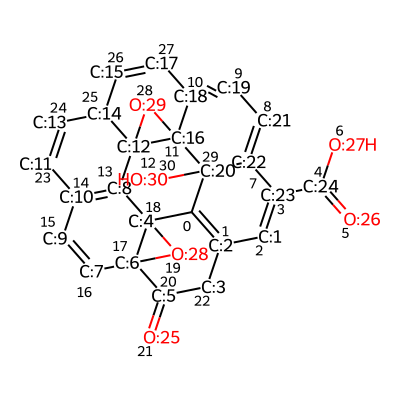

In [4]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

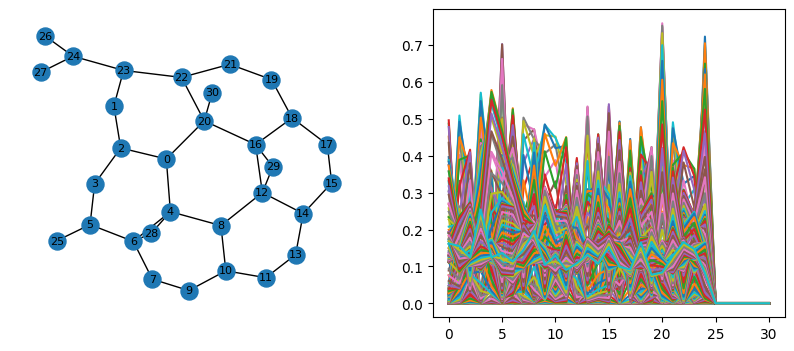

In [5]:
# --- Create subplot for 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show an atomic spectrum from molecule
ax2.plot(data.spectrum)
plt.show()

#### Set up dataset for model

In [6]:
# --- Split into test, validation and test
# train_dataset = dataset[:6000]
# val_dataset = dataset[6001:6999]
# test_dataset = dataset[7000:7895]

train_dataset = dataset[:238]
val_dataset = dataset[239:268]
test_dataset = dataset[269:]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datasets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

torch.save(test_dataset, './datasets/atom_test_dataset_long_317.pt')

Length of training data loader: 238, with a total of 3 datasets
Length of validation data loader: 29, with a total of 3 datasets
Length of testing data loader: 48, with a total of 48 datasets


#### Set up neural network

In [7]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 64, 128, 256]
out_channels = [64, 128, 256, 200]
gnn_type = 'gcn'
heads = 1
drop_ratio = 0.0
graph_pooling = 'mean'

max_degree = -1
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN_node(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN_node(
  (convs): ModuleList(
    (0): GCNConv(15, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
    (3): GCNConv(256, 200)
  )
  (lin): ModuleList(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=200, bias=True)
  )
)
----
Training will be performed on: cuda


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
configs = {
      'device': device,
      'num_layers': 3,
      # The paper use 128 hidden dim, but we use 64 here due to resourse limitation.
      # Similar issues were found in https://github.com/pyg-team/pytorch_geometric/discussions/3388
      # We found this as a limitation of using transformer layer.
      'hidden_dim': 64,
      'num_heads': 1,
      'dropout': 0.3,
      'lr':  0.001,
      'epochs': 500,
      "weight_decay":0.0005,
      'output_dim': 200
  }

model = UniMP(data.num_features, configs['hidden_dim'],
            configs['output_dim'], configs['num_layers'],
            configs['dropout'], heads=configs['num_heads']).to(device)
print(model)

UniMP(
  (convs): ModuleList(
    (0): TransformerConv(15, 64, heads=1)
    (1): TransformerConv(64, 64, heads=1)
    (2): TransformerConv(64, 200, heads=1)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, min_lr=0.000001)

#### Training the neural network

In [10]:
num_epochs = 1000
train_losses = []
val_losses = []
embedding = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, device)

    # if epoch == 299:
    #     for x in node_embedding:
    #         embedding.append(x)

    val_loss = val_test(model, val_loader, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']

    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:5f}, TrainLoss: {train_loss:.7f}, ValLoss: {val_loss:7f}')

print('--------------')
print(f'Final training loss value of: {train_loss:.5f} and validation loss of: {val_loss:.5f}')

Epoch: 000, LR: 0.010000, TrainLoss: 0.1191089, ValLoss: 0.021383
Epoch: 025, LR: 0.010000, TrainLoss: 0.0091756, ValLoss: 0.009368
Epoch: 050, LR: 0.010000, TrainLoss: 0.0083223, ValLoss: 0.008544
Epoch: 075, LR: 0.010000, TrainLoss: 0.0082207, ValLoss: 0.008434
Epoch: 100, LR: 0.010000, TrainLoss: 0.0078291, ValLoss: 0.008254
Epoch: 125, LR: 0.010000, TrainLoss: 0.0075649, ValLoss: 0.007850
Epoch: 150, LR: 0.010000, TrainLoss: 0.0075437, ValLoss: 0.007811
Epoch: 175, LR: 0.010000, TrainLoss: 0.0073859, ValLoss: 0.007803
Epoch: 200, LR: 0.010000, TrainLoss: 0.0072709, ValLoss: 0.007580
Epoch: 225, LR: 0.010000, TrainLoss: 0.0073218, ValLoss: 0.007471
Epoch: 250, LR: 0.010000, TrainLoss: 0.0072978, ValLoss: 0.007684
Epoch: 275, LR: 0.010000, TrainLoss: 0.0071942, ValLoss: 0.007550
Epoch: 300, LR: 0.005000, TrainLoss: 0.0070039, ValLoss: 0.007305
Epoch: 325, LR: 0.005000, TrainLoss: 0.0069661, ValLoss: 0.007273
Epoch: 350, LR: 0.005000, TrainLoss: 0.0069711, ValLoss: 0.007289
Epoch: 375

In [11]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), 'ML_models/' + model_name)

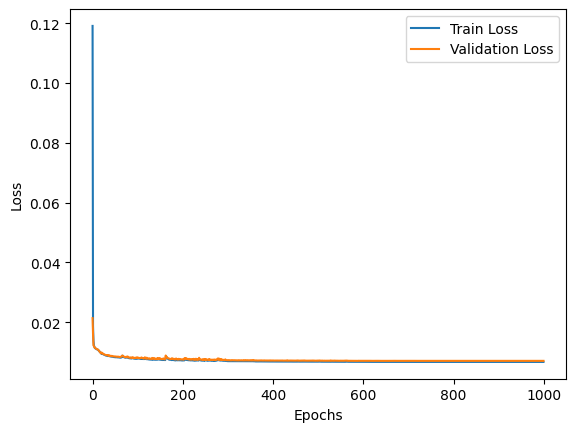

In [12]:
plot_learning_curve(num_epochs, train_losses, val_losses)

In [13]:
model.load_state_dict(torch.load('ML_models/' + model_name, map_location='cpu'))

<All keys matched successfully>

In [14]:
model.eval()
model_pred = []
model_data = []

for data in test_loader:
    data = data.to(device)

    with torch.no_grad():
        pred = model(data)
        model_pred.append(pred)
        model_data.append(data.spectrum)    

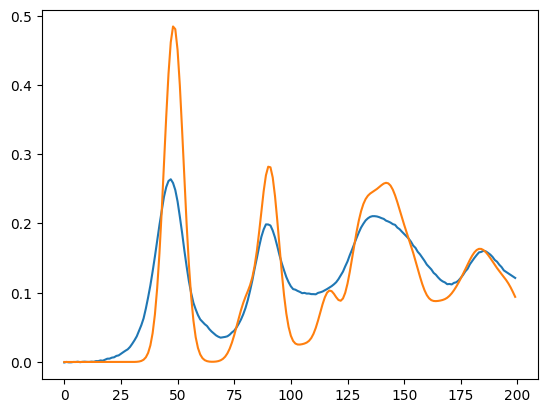

In [17]:
plt.plot(model_pred[0][15].detach().cpu().numpy())
plt.plot(model_data[0][15].detach().cpu().numpy())
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE

trans = transform(n_components=3, perplexity=30, early_exaggeration=12, n_iter=1000)
x_reduced = trans.fit_transform(node_embedding.cpu().detach().numpy())
x_reduced.shape

(112, 3)

In [ ]:
node_embedding.shape

torch.Size([112, 256])

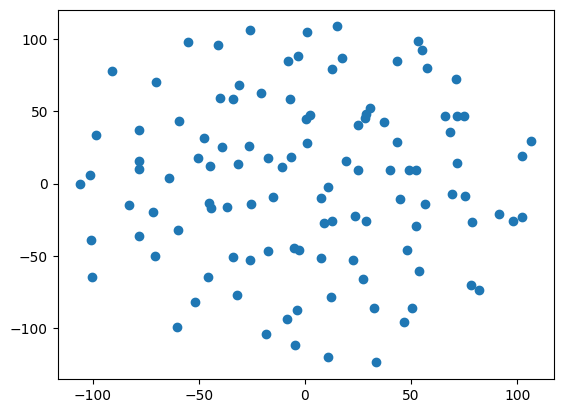

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1])
plt.show()

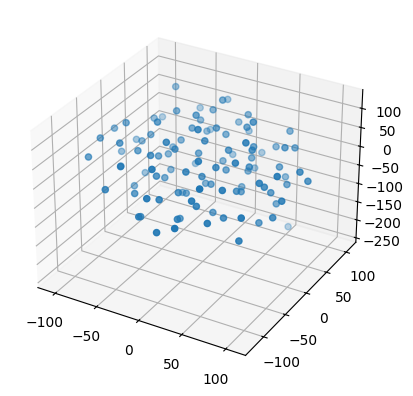

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x_reduced[:,0], x_reduced[:,1], x_reduced[:,2])
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit(node_embedding.cpu().detach().numpy())

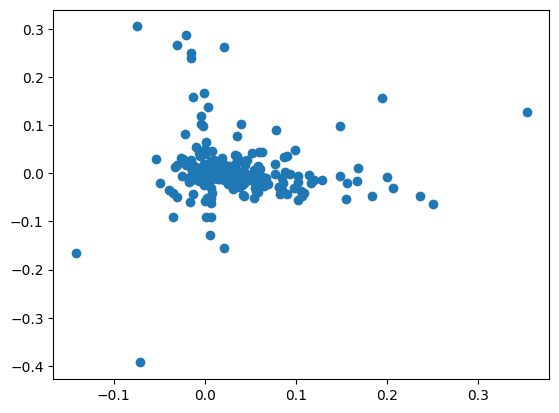

In [ ]:
plt.scatter(pca_fit.components_[0], pca_fit.components_[1])
plt.show()